In [29]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mean_squared_error
import math
from config_notebooks.config import set_wd
set_wd()

In [30]:
df = pd.read_excel("./data/data.xlsx",index_col=0)[:"11-2022"]

In [31]:
y = df["pp"]
model = pm.auto_arima(
                    y=y, start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=9, max_q=9, # maximum p and q
                    m=12,              # periodicity of 12 months as the data timeline is in months
                    d=1,           # let the model determine 'd'
                    seasonal=True,   # Seasonality
                    start_P=0, 
                    D=1, 
                    max_order=20,
                    with_intercept=True,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=2889.939, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=2843.042, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2887.939, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=2887.982, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=2827.033, Time=1.12 sec
 ARIMA(1,1,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2830.120, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=2824.080, Time=1.55 sec
 ARIMA(2,1,0)(1,1,0)[12] intercept   : AIC=2841.152, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(2,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(3,1,0)(2,1,0)[12] intercept   : AIC=2825.2

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  215
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1406.039
Date:                            Mon, 20 Nov 2023   AIC                           2822.079
Time:                                    20:44:51   BIC                           2838.620
Sample:                                01-31-2005   HQIC                          2828.772
                                     - 11-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1811      0.062     -2.924      0.003      -0.302      -0.060
ar.L2         -0.1585      0.070     -2.269      0.023      -0.295      -0.022
ar.S.L12      -0.6096      0.074     -8.275      0.000      -0.754      -0.465
ar.S.L24      -0.3149      0.072     -4.378      0.000      -0.456      -0.174
sigma2      6.361e+04   6658.745      9.552      0.000    5.06e+04    7.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.88   Prob(JB):                         0.80
Heteroskedasticity (H):               1.47   Skew:                             0.09
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

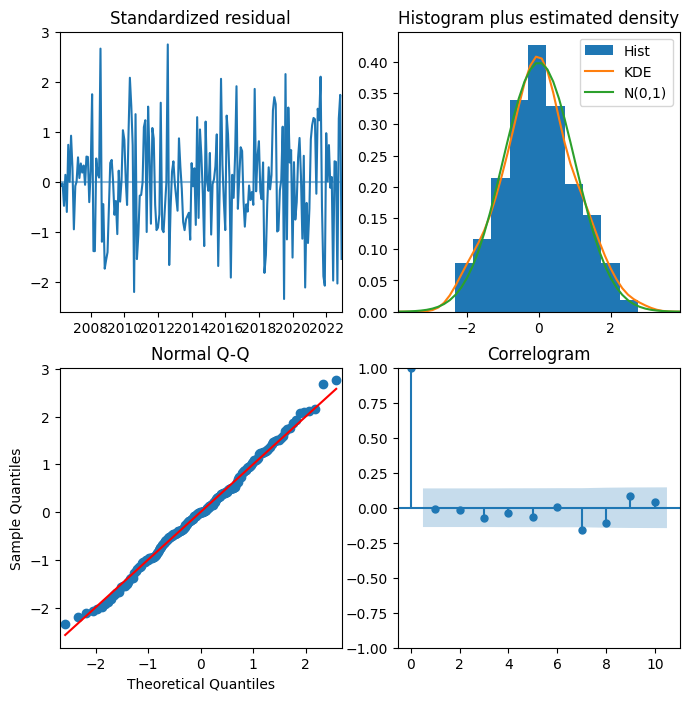

In [33]:
model.plot_diagnostics(figsize=(8,8))
plt.show()

In [34]:
forecast, confint = model.predict(n_periods=6, return_conf_int=True)
forecast = pd.concat([model.fittedvalues(), forecast])
forecast

2005-01-31       0.000000
2005-02-28     504.434896
2005-03-31     497.605423
2005-04-30     655.174250
2005-05-31     933.682678
                 ...     
2023-01-31    1914.657690
2023-02-28    1773.902711
2023-03-31    2039.062429
2023-04-30    2282.018269
2023-05-31    2388.629860
Length: 221, dtype: float64

In [35]:
my_order = model.order #se consigue la estacionariedad
my_seasonal_order = model.seasonal_order
sarima_fut = SARIMAX(df[["pp"]],
                    #  exog=X, 
                     order = my_order, seasonal_order=my_seasonal_order) #!!!
model_fit = sarima_fut.fit()
forecast = model_fit.forecast(6, alpha = .1)
forecast = pd.concat([model_fit.fittedvalues, forecast])
ic = model_fit.get_forecast(6,alpha = .1, 
                            # exog = X_new
                            ).conf_int().rename({f"lower pp": "lower", f"upper pp":"upper"},axis=1)
forecast_test_df = pd.DataFrame({"prediccion":forecast,
                                 "observado": df["pp"],})
forecast_test_df = pd.concat([forecast_test_df, ic], axis=1)
fig = go.Figure(go.Scatter(x = forecast_test_df.index, y = forecast_test_df["prediccion"], name = "Predicción"))
fig.add_trace(go.Scatter(x = df.index, y = df["pp"], name = "Observado"))
fig.update_layout(template = None, title_text = "Estimación de las exportaciones de los productos primarios a 6 meses")
fig.add_vline(x = forecast_test_df.index[-6], line_width=3, line_dash="dash", line_color="green")


c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [36]:
variable = "pp"
seasonal = True
m = 12
y = df[variable]
if variable == "pre":
    y = np.log(df["pre"]+1)
if variable == "gap" or variable == "er_cp":
    seasonal = False
    m = 1    
model = pm.auto_arima(
                y=y, start_p=1, start_q=1,
                test='adf',       # use adftest to find optimal 'd'
                max_p=9, max_q=9, # maximum p and q
                m=m,              # periodicity of 12 months as the data timeline is in months
                d=None,           # let the model determine 'd'
                seasonal=seasonal,   # Seasonality
                start_P=0, 
                D=None, 
                max_order=20,
                with_intercept=True,
                trace=True,
                error_action='ignore',  
                suppress_warnings=True, 
                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2996.839, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3284.497, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2984.091, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3088.262, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3720.841, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3020.526, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2976.626, Time=2.75 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2973.942, Time=2.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2957.466, Time=0.95 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2996.549, Time=0.45 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2962.233, Time=2.17 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2988.473, Time=0.76 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3201.574, Time=0.73 sec
 ARIMA(2,0,0)(1,0,1)[12]

In [57]:
predictions, confidence_intervals = model.predict(n_periods=6, return_conf_int=True)

obs_pred_df = pd.DataFrame({
    "prediccion": predictions,
    "lower": confidence_intervals[:, 0],
    "upper": confidence_intervals[:, 1]
})
fitted = model.fittedvalues()
obs_pred_df = obs_pred_df.merge(df[variable], how="outer", left_index=True, right_index=True)
obs_pred_df["prediccion"] = obs_pred_df["prediccion"].fillna(fitted)
obs_pred_df = obs_pred_df.rename({variable : "observado"}, axis=1)
obs_pred_df

,prediccion,lower,upper,observado
2005-01-31,1194.138275,NaN,NaN,508.020737
2005-02-28,607.833597,NaN,NaN,500.539941
2005-03-31,599.611468,NaN,NaN,656.181802
2005-04-30,727.651186,NaN,NaN,939.064907
2005-05-31,961.568763,NaN,NaN,1028.823820
...,...,...,...,...
2023-01-31,1583.868585,1010.303825,2157.433344,NaN
2023-02-28,1465.085967,813.476045,2116.695889,NaN
2023-03-31,1625.372405,924.028600,2326.716210,NaN
2023-04-30,1764.875190,1030.549769,2499.200610,NaN


In [73]:
def plot_sarima_variable(variable:str, df:pd.DataFrame):
    seasonal = True
    m = 12
    y = df[variable]
    if variable == "pre":
        y = np.log(df["pre"]+1)
    if variable == "gap" or variable == "er_cp":
        seasonal = False
        m = 1    
    model = pm.auto_arima(
                    y=y, start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=9, max_q=9, # maximum p and q
                    m=m,              # periodicity of 12 months as the data timeline is in months
                    d=None,           # let the model determine 'd'
                    seasonal=seasonal,   # Seasonality
                    start_P=0, 
                    D=None, 
                    max_order=20,
                    with_intercept=True,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)
    forecast, confidence_intervals = model.predict(n_periods=6, return_conf_int=True, alpha=.1)
    obs_pred_df = pd.DataFrame({
        "prediccion": forecast,
        "lower": confidence_intervals[:, 0],
        "upper": confidence_intervals[:, 1]
    })
    fitted = model.fittedvalues()
    if variable == "pre":
        obs_pred_df = np.exp(obs_pred_df)
        fitted = np.exp(fitted)
    obs_pred_df = obs_pred_df.merge(df[variable], how="outer", left_index=True, right_index=True)
    obs_pred_df["prediccion"] = obs_pred_df["prediccion"].fillna(fitted)
    obs_pred_df = obs_pred_df.rename({variable : "observado"}, axis=1)
    plot_predicc_obs_exog = go.Figure()
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x = obs_pred_df.index[-6:], y = obs_pred_df.lower[-6:], name = "Predicción_lower"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x = obs_pred_df.index[-6:], y = obs_pred_df.upper[-6:], name = "Predicción_upper", fill='tonexty'))
    plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-6], line_width=3, line_dash="dash", line_color="green")
    plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"{variable}\"<br><sup>{model}",
    font_family = "georgia")
    plot_predicc_obs_exog.show()
    model.plot_diagnostics(figsize=(8,8))
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2996.839, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3284.497, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2984.091, Time=0.76 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3088.262, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3720.841, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3020.526, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2976.626, Time=2.55 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2973.942, Time=2.02 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2957.466, Time=0.81 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2996.549, Time=0.57 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2962.233, Time=2.99 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2988.473, Time=0.84 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3201.574, Time=0.77 sec
 ARIMA(2,0,0)(1,0,1)[12]

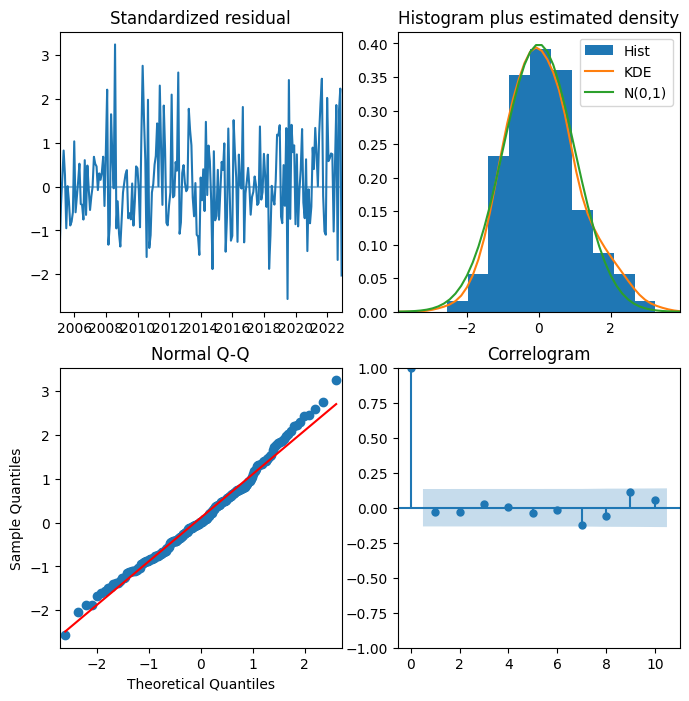

In [74]:
plot_sarima_variable(variable="pp", df = df)